In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('case.csv')

In [3]:
df = df.iloc[::-1]
df

,y,x1,x2,x3,x4,x5
274,91.6261,0.695,6.63,1570.90,22.6,115232
273,91.9626,0.819,6.23,1852.90,37.9,115573
272,92.3118,0.857,6.05,1946.30,19.4,115932
271,92.8872,0.732,5.85,2391.20,14.7,116631
270,93.1620,0.896,6.15,2209.90,20.9,117295
...,...,...,...,...,...,...
4,104.4852,3.283,3.10,1822.57,4.4,400415
3,104.4135,2.793,3.13,1688.85,18.0,403957
2,104.8129,2.578,3.56,1736.47,4.6,405466
1,104.7474,2.837,4.04,1462.59,4.4,405948


In [4]:
df["Date"] = pd.date_range('2000-01-01', '2022-12-01', freq='M')

In [5]:
df.index = df["Date"]
df

,y,x1,x2,x3,x4,x5,Date
Date,,,,,,,
2000-01-31,91.6261,0.695,6.63,1570.90,22.6,115232,2000-01-31
2000-02-29,91.9626,0.819,6.23,1852.90,37.9,115573,2000-02-29
2000-03-31,92.3118,0.857,6.05,1946.30,19.4,115932,2000-03-31
2000-04-30,92.8872,0.732,5.85,2391.20,14.7,116631,2000-04-30
2000-05-31,93.1620,0.896,6.15,2209.90,20.9,117295,2000-05-31
...,...,...,...,...,...,...,...
2022-07-31,104.4852,3.283,3.10,1822.57,4.4,400415,2022-07-31
2022-08-31,104.4135,2.793,3.13,1688.85,18.0,403957,2022-08-31
2022-09-30,104.8129,2.578,3.56,1736.47,4.6,405466,2022-09-30


In [6]:
df_2 = df.drop('x1', axis=1)
df_3 = df_2.drop('x2', axis=1)
df_4 = df_3.drop('x3', axis=1)
df_5 = df_4.drop('x4', axis=1)
df_6 = df_5.drop('x5', axis=1)

df_6

,y,Date
Date,,
2000-01-31,91.6261,2000-01-31
2000-02-29,91.9626,2000-02-29
2000-03-31,92.3118,2000-03-31
2000-04-30,92.8872,2000-04-30
2000-05-31,93.1620,2000-05-31
...,...,...
2022-07-31,104.4852,2022-07-31
2022-08-31,104.4135,2022-08-31
2022-09-30,104.8129,2022-09-30


In [7]:
df_6 = df_6.sort_index(ascending=True,axis=0)
data = pd.DataFrame(index=range(0,len(df_6)),columns=['Date','y'])
for i in range(0,len(data)):
    data["Date"][i]=df_6["Date"][i]
    data["y"][i]=df_6["y"][i]
data.head()

,Date,y
0,2000-01-31 00:00:00,91.6261
1,2000-02-29 00:00:00,91.9626
2,2000-03-31 00:00:00,92.3118
3,2000-04-30 00:00:00,92.8872
4,2000-05-31 00:00:00,93.162


In [8]:
scaler=MinMaxScaler(feature_range=(0,1))
data.drop("Date",axis=1,inplace=True)
final_data = data.values
train_data=final_data[0:220,:]
valid_data=final_data[220:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)
x_train_data = []
y_train_data = []
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)

In [9]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data=data[len(data)-len(valid_data)-60:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [10]:
lstm_model.compile(loss="mean_squared_error", optimizer="adam")
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

160/160 - 7s - loss: 0.0296 - 7s/epoch - 43ms/step


In [11]:
X_test = []
for i in range(60,model_data.shape[0]):
    X_test.append(model_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [12]:
predicted_y=lstm_model.predict(X_test)
predicted_y=scaler.inverse_transform(predicted_y)

2/2 [==============================] - 1s 15ms/step


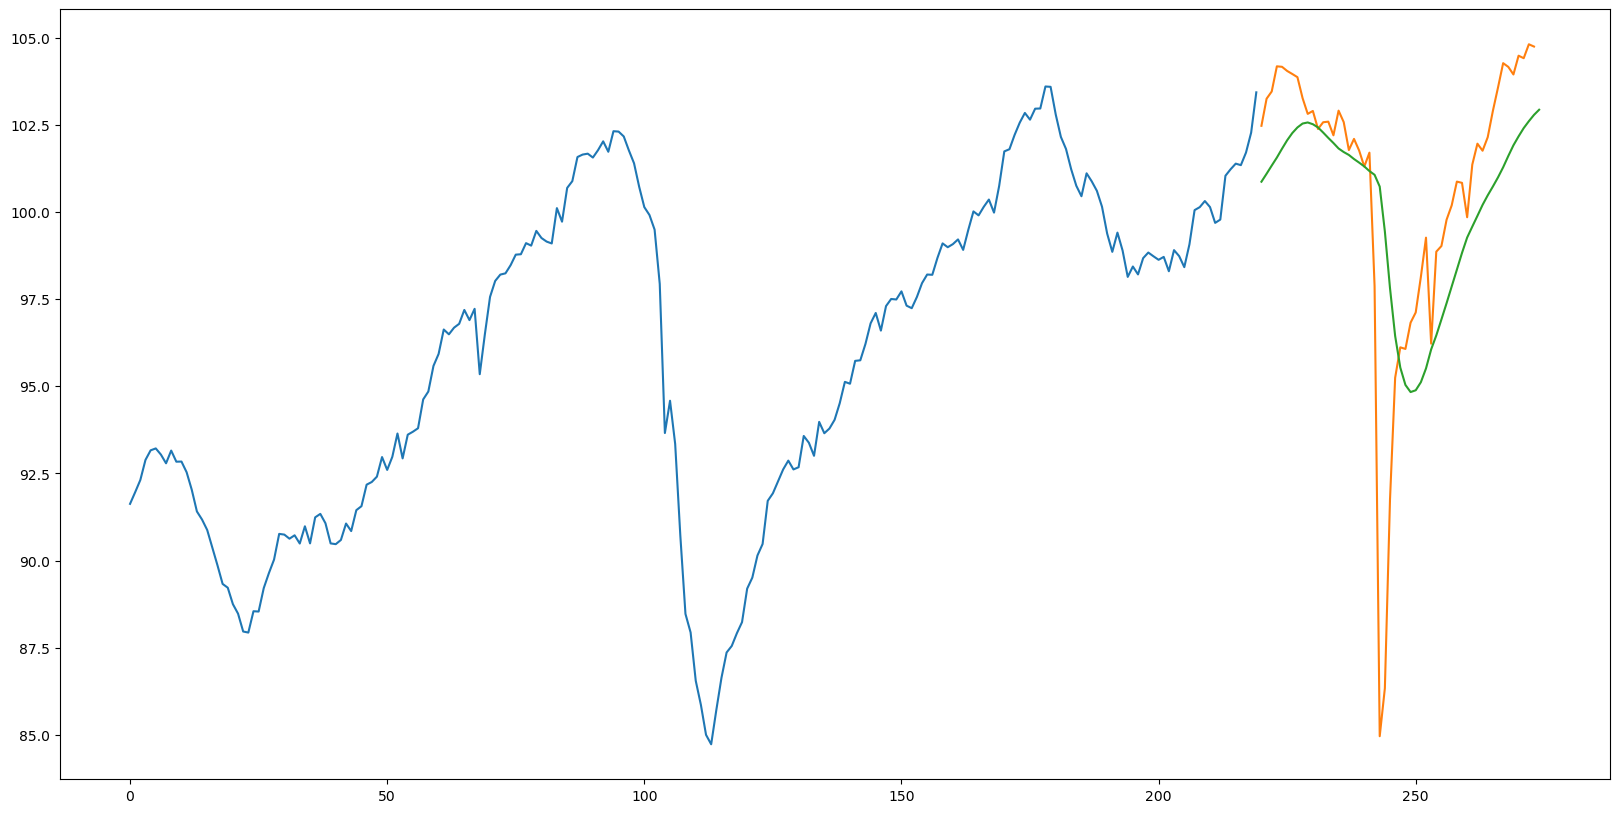

In [13]:
train_data=data[:220]
valid_data=data[220:]
valid_data["Predictions"]=predicted_y
plt.plot(train_data["y"])
plt.plot(valid_data[["y","Predictions"]])